# Pokemon Classify Pytorch Lightning CNN

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [13]:
dataset0= ImageFolder(root="/kaggle/input/pokemonclassification/PokemonData")

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [ ]:
import pickle
import os
    
class PokemonDataModule(Dataset):
    def __init__(self, data_dir, transform, train_indices=None, test_indices=None):
        self.dataset = ImageFolder(root=data_dir, transform=transform)
        self.class_names = self.dataset.classes


    def __len__(self):
        # Assuming ImageFolder provides len() for dataset size
        return len(dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def plot_examples(self, dataset, class_names, n_rows=4, n_cols=4):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))
        for i, ax in enumerate(axes.flat):
            idx = np.random.randint(0, len(self.dataset))
            img, label = self.dataset[idx]
            ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
            ax.set_title(self.class_names[label])
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Visualize examples from the train dataset
plot_examples(train_dataset, class_names)
        
    def get_dataloaders(self,
                        indices_file='indices.pkl',
                        train_transform=None,
                        test_transform=None,
                        batch_size = 32
                       ):
        if not(os.path.isfile(indices_file)):
            # Split indices for train and test (80/20 split) with class balance
            self.train_indices, self.test_indices = train_test_split(
                range(len(dataset)),
                test_size=0.2,
                stratify=dataset.targets,
                random_state=42
            )
            with open(indices_file, 'wb') as f:
                pickle.dump([train_indices, test_indices], f)
        else:
            with open(indices_file, 'rb') as f:
                self.train_indices, self.test_indices = pickle.load(f)
            
        train_dataset = Subset(dataset, self.train_indices)
        test_dataset = Subset(dataset, self.test_indices)

        trainloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

Number of classes: 150
Train dataset size: 5456
Test dataset size: 1364


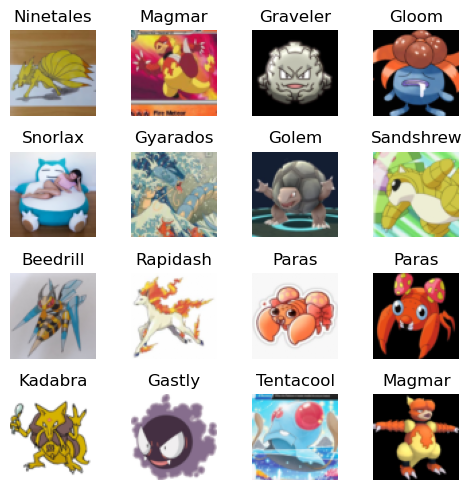

In [17]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Define the dataset and transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),       # Convert PIL images to tensors
])

DATA_DIR = ="/kaggle/input/pokemonclassification/PokemonData"
dataset = ImageFolder(root=DATA_DIR, transform=transform)

# Get class names
class_names = dataset.classes
print(f"Number of classes: {len(class_names)}")

# Split indices for train and test (80/20 split) with class balance
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Plot a grid of examples
def plot_examples(dataset, class_names, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize examples from the train dataset
plot_examples(train_dataset, class_names)

In [ ]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "/kaggle/input/pokemonclassification/PokemonData"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms  # Assuming usage of torchvision for image transformations


ROOT_DIR = "/kaggle/input/pokemonclassification/PokemonData"

class PokemonDataModule(Dataset):
    def __init__(self, root_dir):
        self.dataset = datasets.ImageFolder(root=self.root_dir)

    def __len__(self):
        # Assuming ImageFolder provides len() for dataset size
        return len(dataset)

    def __getitem__(self, index):
        image, label = datasets.ImageFolder(root=self.root_dir)[index]
        return image, label

    def create_dataloaders(self,
                           train_transform,
                           test_transform,
                           test_split=0.2,
                           batch_size=32):
        """
        Creates training and testing data loaders from a dataset directory.
    
        Args:
            root_dir (str): Path to the directory containing the image dataset.
            train_transform (callable, optional): Transformation to apply to training images. Defaults to None.
            test_transform (callable, optional): Transformation to apply to training images. Defaults to None.
            test_split (float, optional): Proportion of data to use for testing. Defaults to 0.2.
            batch_size (int, optional): Batch size for the data loaders. Defaults to 32.

    
        Returns:
            tuple: A tuple containing the training and testing data loaders.
        """
    
        dataset = PokemonDataModule(root_dir)
        n_data = len(dataset)
        n_train = int(n_data * (1 - test_split))
        n_test = n_data - n_train

        train_dataset, test_dataset = random_split(dataset, [n_train, n_test])
    
        train_dataloader = DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      transform= train_transform)
        
        test_dataloader = DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     test_transform)
    
        return train_dataloader, test_dataloader

In [ ]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [ ]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=20)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

In [ ]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))